In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [6]:
data = pd.read_csv('Datasets/Burnout/train.csv')

In [7]:
data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [8]:
data["Date of Joining"].value_counts()

Date of Joining
2008-01-06    86
2008-05-21    85
2008-02-04    82
2008-07-16    81
2008-07-13    80
              ..
2008-06-27    44
2008-07-06    44
2008-07-04    43
2008-12-24    43
2008-12-07    39
Name: count, Length: 366, dtype: int64

### Target is Burn Rate

In [9]:
def preprocess_inputs(df):
    df = df.copy()

    # Employee ID non-correlati with their burnout
    df = df.drop('Employee ID', axis=1)
    
    # Need to drop rows where target value is missing
    missing_target_rows = df.loc[df['Burn Rate'].isna(), :].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)

    # Fill missing non-target values with mean values
    for column in ['Resource Allocation', 'Mental Fatigue Score']:
        df[column] = df[column].fillna(df[column].mean())

    # Date features
    df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])
    df['Month'] = df['Date of Joining'].apply(lambda x: x.month)
    df['Day'] = df['Date of Joining'].apply(lambda x: x.day)
    # Year is the same for every row (2008) so we can drop it
    df = df.drop('Date of Joining', axis=1)

    # Binary features extract
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Company Type'] = df['Company Type'].replace({'Product': 0, 'Service': 1})
    df['WFH Setup Available'] = df['WFH Setup Available'].replace({'No': 0, 'Yes': 1})

    return df

In [10]:
pure_data = preprocess_inputs(data)
pure_data.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Month,Day
0,0,1,0,2.0,3.000000,3.8,0.16,9,30
1,1,1,1,1.0,2.000000,5.0,0.36,11,30
2,0,0,1,2.0,4.483831,5.8,0.49,3,10
3,1,1,1,1.0,1.000000,2.6,0.20,11,3
4,0,1,0,3.0,7.000000,6.9,0.52,7,24


### Outliers


<Axes: xlabel='Mental Fatigue Score'>

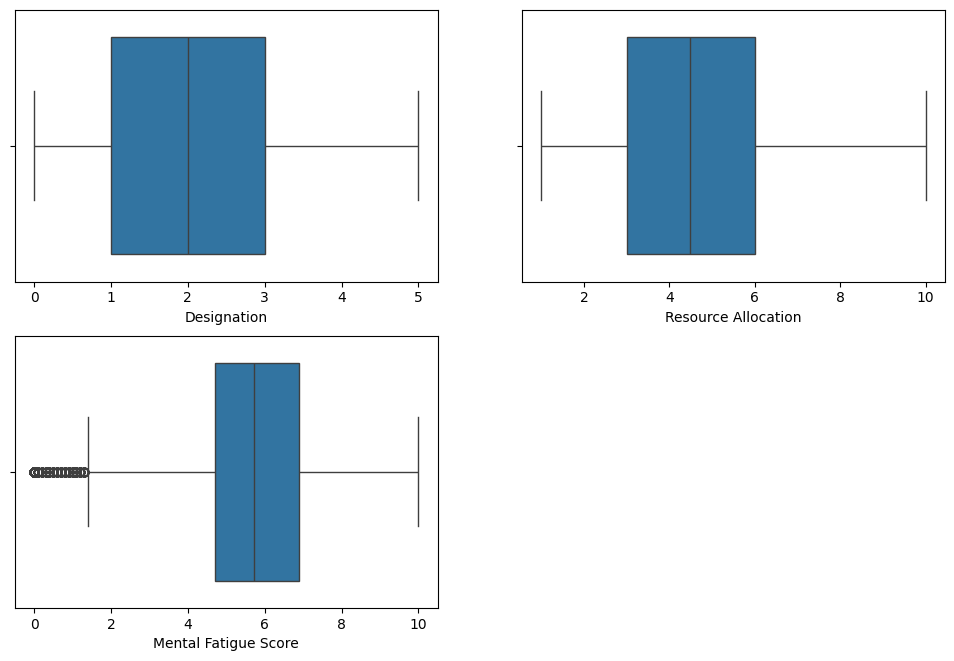

In [18]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
sns.boxplot(data=pure_data, x='Designation')

plt.subplot(3, 2, 2)
sns.boxplot(data=pure_data, x='Resource Allocation')

plt.subplot(3, 2, 3)
sns.boxplot(data=pure_data, x='Mental Fatigue Score')

### Target Frequency

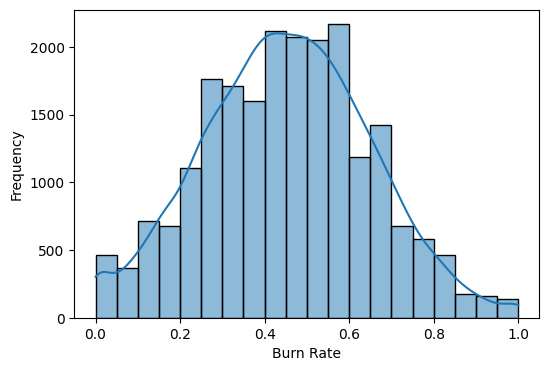

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(pure_data["Burn Rate"], kde=True, bins=20)
plt.xlabel("Burn Rate")
plt.ylabel("Frequency")
plt.show()

### Correlation matrix

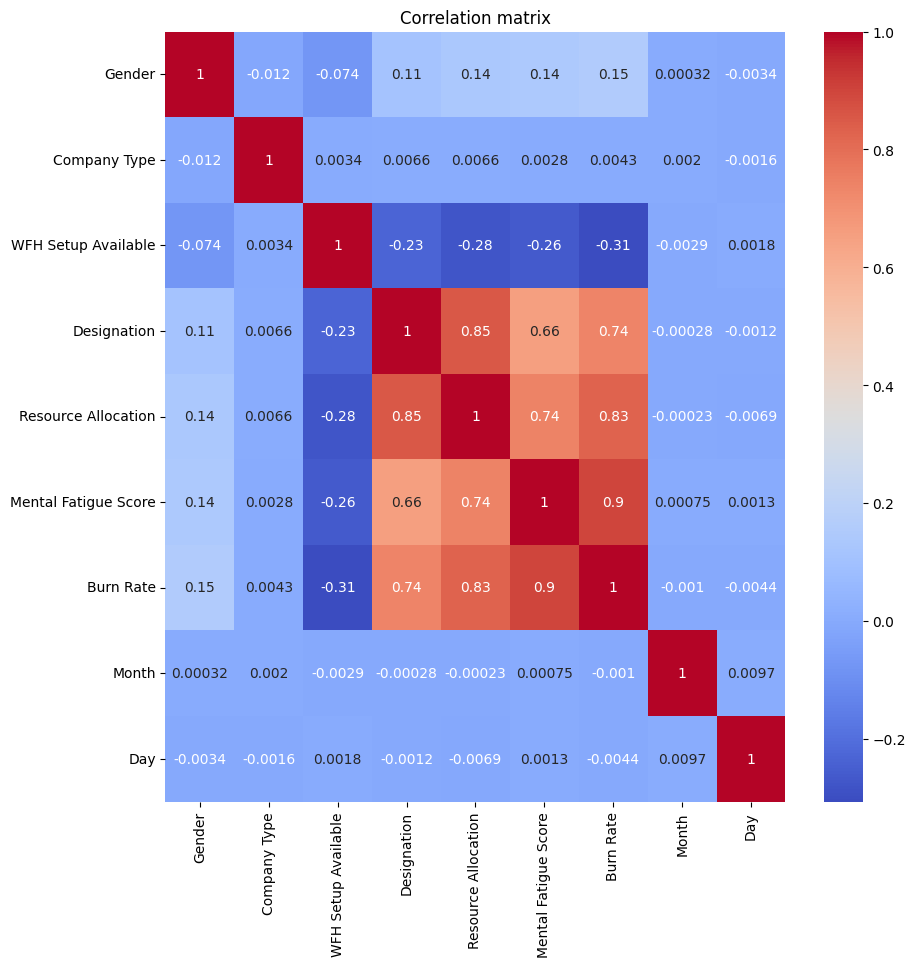

In [ ]:
correlation_matrix = pure_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

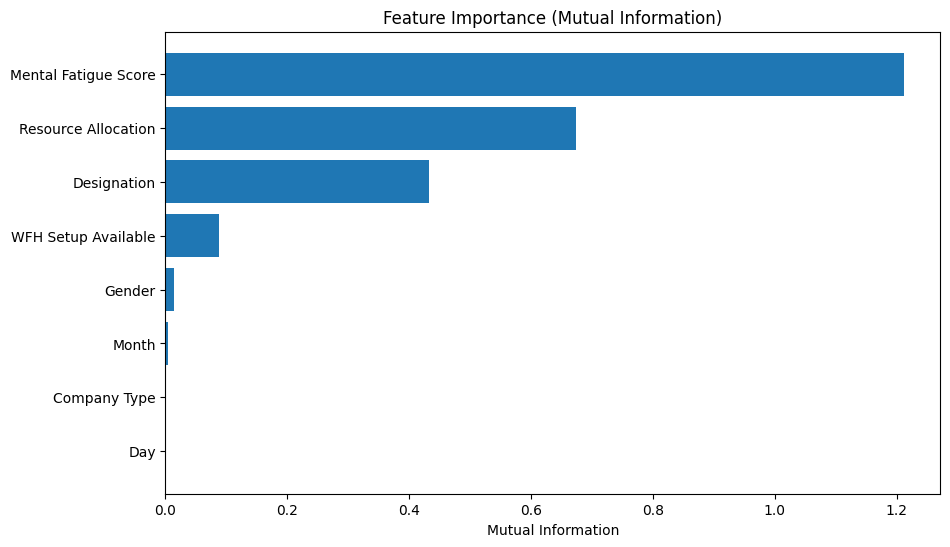

In [ ]:
from sklearn.feature_selection import mutual_info_regression

x = pure_data.drop('Burn Rate', axis=1)
y = pure_data['Burn Rate']
# Вычисление важности признаков с использованием mutual information на ваших данных X_train и y_train 
mutual_info = mutual_info_regression(x, y, random_state=42)
# Создание DataFrame для отображения результатов
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': mutual_info})
# Сортировка по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Mutual Information')
plt.title('Feature Importance (Mutual Information)')
plt.show()

In [ ]:
def drop_unnecessary_correlation(data):
    data = data.copy()

    # Drop low importance
    data = data.drop('Month', axis=1)
    data = data.drop('Day', axis=1)

    return data

In [ ]:
pure_data = drop_unnecessary_correlation(pure_data)

In [ ]:
pure_data.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,1,0,2.0,3.000000,3.8,0.16
1,1,1,1,1.0,2.000000,5.0,0.36
2,0,0,1,2.0,4.483831,5.8,0.49
3,1,1,1,1.0,1.000000,2.6,0.20
4,0,1,0,3.0,7.000000,6.9,0.52


### Pairplot

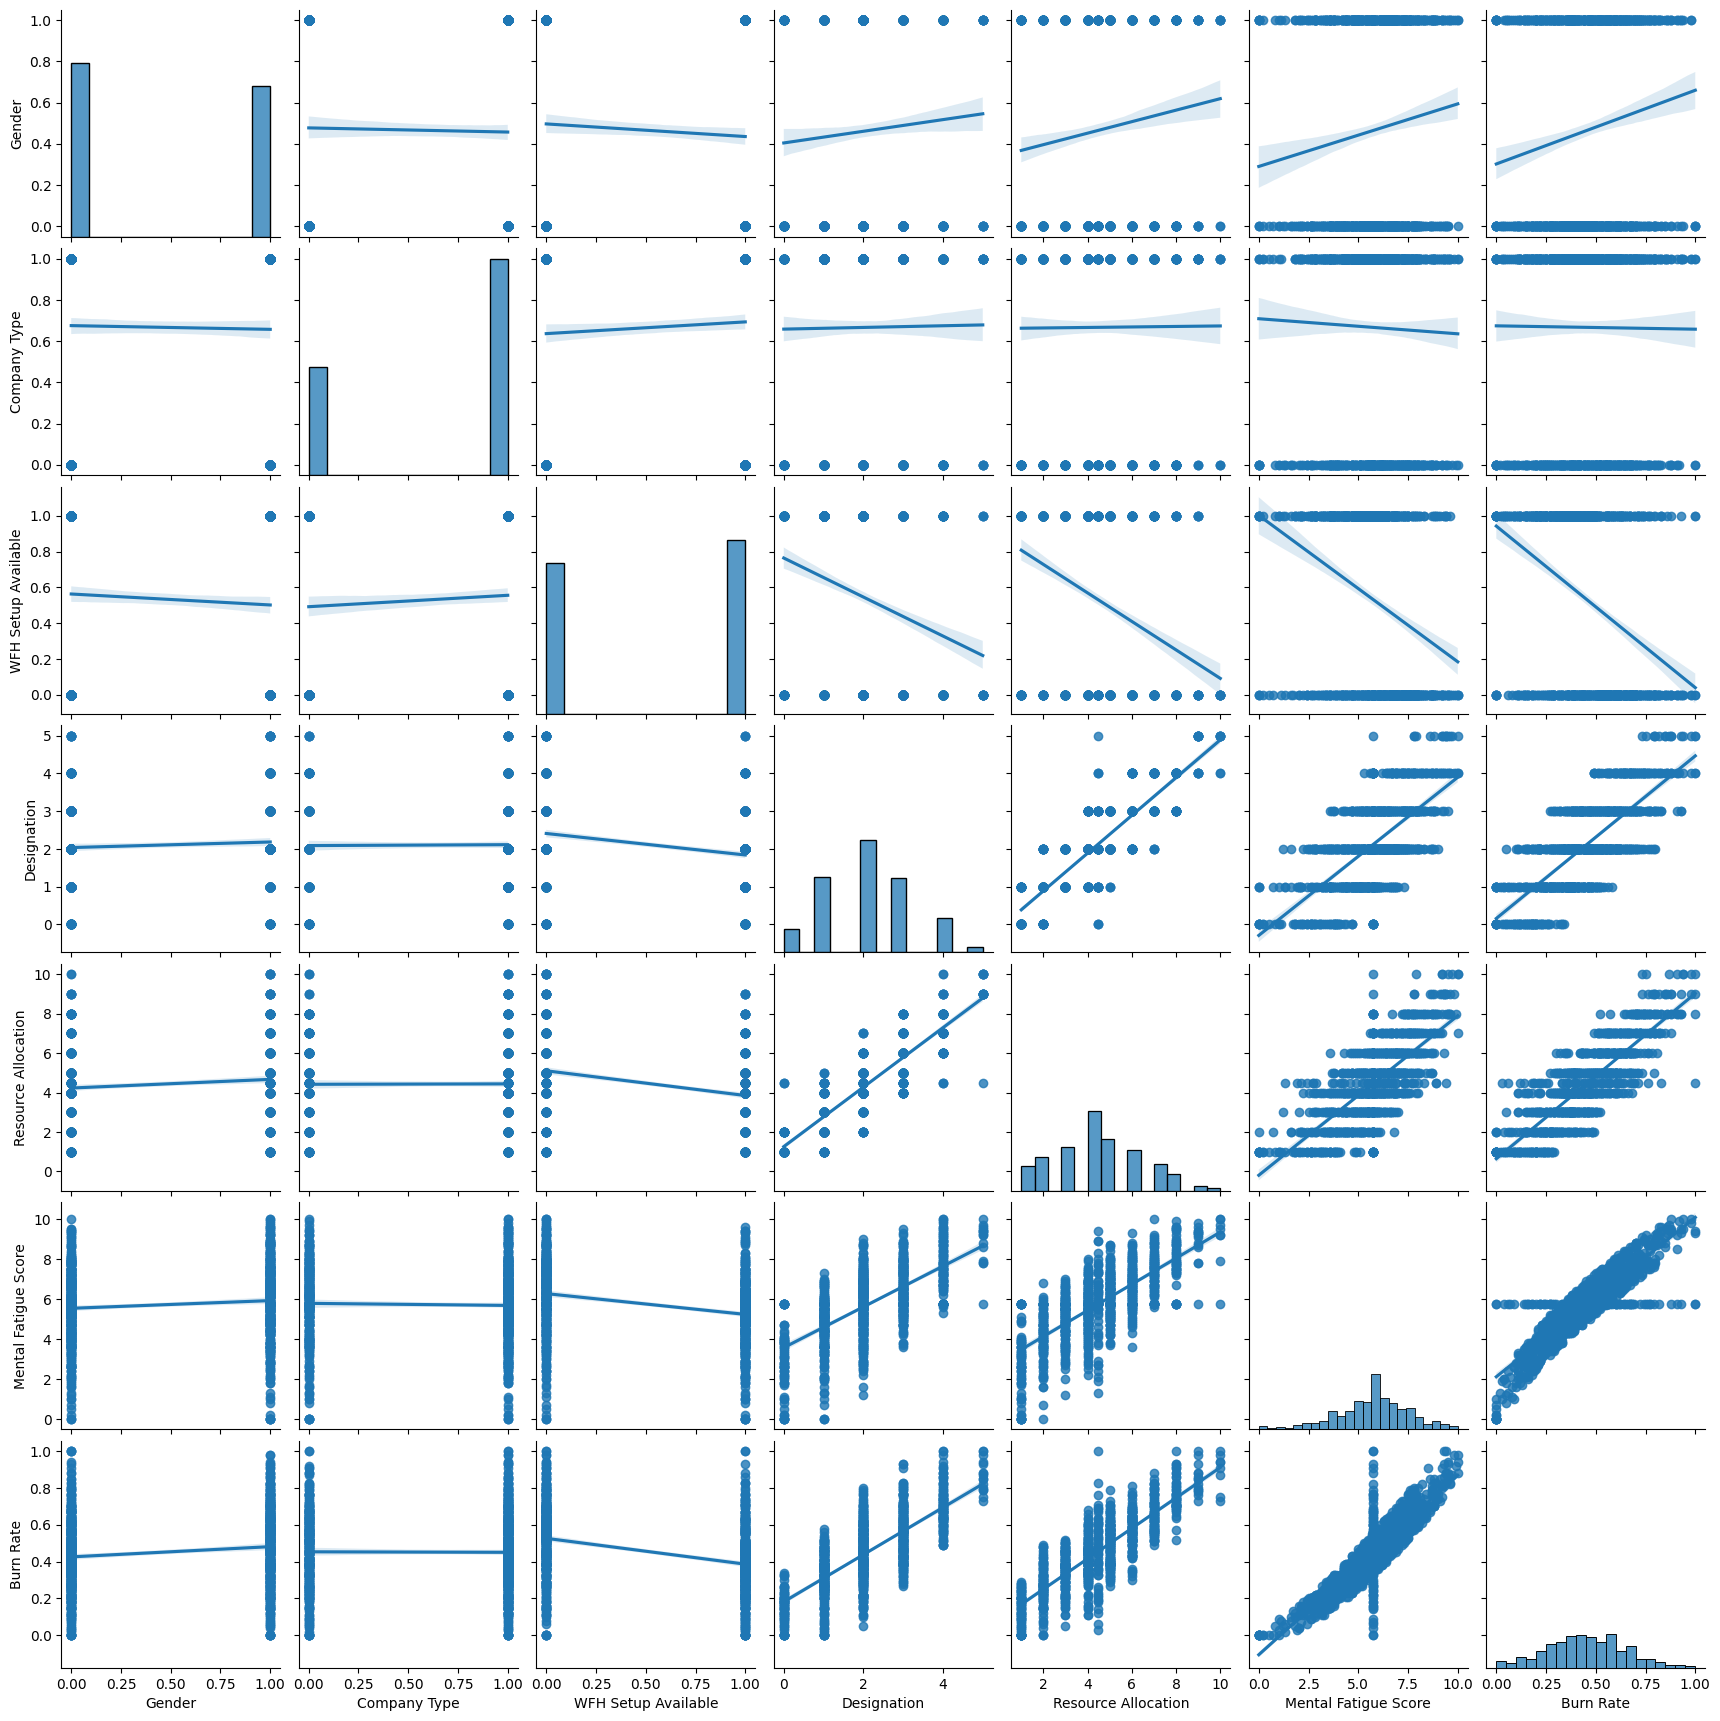

In [ ]:
sns.pairplot(pure_data[:1000], kind="reg") 

In [ ]:
pure_data = pd.get_dummies(pure_data, columns=['Designation',], dtype=int)

In [ ]:
x = pure_data.drop('Burn Rate', axis=1)
y = pure_data['Burn Rate']

### Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [ ]:
x_train_scaled = x_train.loc[:, ['Resource Allocation', 'Mental Fatigue Score']]
x_test_scaled = x_test.loc[:, ['Resource Allocation', 'Mental Fatigue Score']]

In [ ]:
scaler = MinMaxScaler().fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)
x_test_scaled = scaler.transform(x_test_scaled)
x_train = np.concatenate((x_train_scaled, x_train.drop(['Resource Allocation', 'Mental Fatigue Score'], axis=1).to_numpy()), axis=1)
x_test = np.concatenate((x_test_scaled, x_test.drop(['Resource Allocation', 'Mental Fatigue Score'], axis=1).to_numpy()), axis=1)

In [ ]:
result = pd.DataFrame({'Model':[], 'MSE':[], 'MAE':[], 'R2':[]})

In [ ]:
def test_model(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train)

    # Feed the scaled training set and get the predictions
    y_hat = model.predict(x_test)

    test_mse = mean_squared_error(y_test, y_hat)
    test_mae = mean_absolute_error(y_test, y_hat)
    test_r2 = r2_score(y_test,y_hat)
    return test_mse, test_mae, test_r2

In [ ]:
models = []
linear = LinearRegression()
decision_tree = DecisionTreeRegressor()
rendom_forest = RandomForestRegressor()
svr = SVR()
k_neighbors = KNeighborsRegressor()
mlp = MLPRegressor()
gradient_boosting = GradientBoostingRegressor()
models.append(linear)
models.append(decision_tree)
models.append(rendom_forest)
models.append(svr)
models.append(k_neighbors)
models.append(mlp)
models.append(gradient_boosting)

for model in models:
    test_mse, test_mae, test_r2 = test_model(model, x_train, y_train, x_test, y_test)
    result.loc[len(result.index)] = [str(model), test_mse, test_mae, test_r2] 

In [ ]:
result.sort_values(by=['MSE', 'MAE'])

,Model,MSE,MAE,R2
6,GradientBoostingRegressor(),0.003669,0.047621,0.906122
2,RandomForestRegressor(),0.003950,0.049249,0.898951
4,KNeighborsRegressor(),0.004221,0.050826,0.892012
3,SVR(),0.004426,0.052350,0.886761
1,DecisionTreeRegressor(),0.004452,0.052083,0.886097
5,MLPRegressor(),0.004481,0.051383,0.885366
0,LinearRegression(),0.004851,0.052918,0.875893


### NN

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
x_train = torch.tensor(x_train).float().to(device)
x_test = torch.tensor(x_test).float().to(device)
y_train = torch.tensor(y_train.to_numpy()).float().to(device)
y_test = torch.tensor(y_test.to_numpy()).float().to(device)

In [ ]:
class NN(nn.Module):
    def __init__(self, input):
        super(NN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input, 12),
                                 nn.ReLU(),
                                 nn.Linear(12, 1))

    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
model_nn = NN(len(x_train[0]))
model_nn.to(device)

NN(
  (fc1): Sequential(
    (0): Linear(in_features=11, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = Adam(params=model_nn.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [ ]:
num_iter = 200
losses = []
train_loop = tqdm(range(num_iter))
train_loop.set_description_str("Model training")
for i in train_loop:
    outputs = model_nn(x_train)
    loss = loss_func(outputs, y_train)
    losses.append(loss.item())
    train_loop.set_postfix_str(f"Current error = {loss.item()}")
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Model training:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\Надя\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([17300])) that is different to the input size (torch.Size([17300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Model training: 100%|██████████| 200/200 [00:14<00:00, 14.25it/s, Current error = 0.039666853845119476]


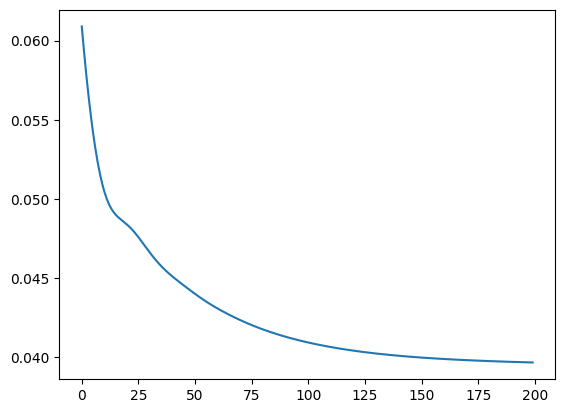

In [ ]:
plt.plot(losses)

In [ ]:
import random 
j = random.randint(0, len(y_test))

print(f"\nReal Burn Rate = {y_test[j].item()}")
print(f"Predicted Burn Rate = {model_nn(x_test[j]).item()}")


Real Burn Rate = 0.3499999940395355
Predicted Burn Rate = 0.473798930644989


In [ ]:
results = model_nn(x_test).cpu().detach().numpy()
y_real = y_test.cpu().detach().numpy()
mse = mean_squared_error(y_real, results)
mae = mean_absolute_error(y_real, results)
r2 = r2_score(y_real, results)

print(f"mse =\t{mse}\nmae =\t{mae}\nr2 =\t{r2}")

mse =	0.0377657487988472
mae =	0.1560211181640625
r2 =	0.03376091493816158
